In [14]:
%matplotlib inline
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from IPython.core.display import HTML, display
import os,time

import theano
import theano.tensor as T

import lasagne

In [2]:
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

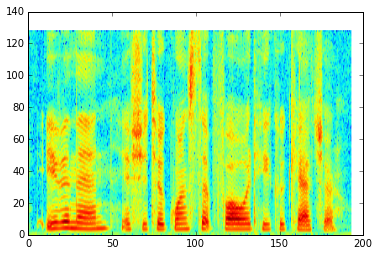

(129, 385)

In [3]:
[framerate,sound]=wavfile.read("SI1027_.wav")
(spectrum, freqs, t, im)=specgram(sound,NFFT=256,Fs=256)
plt.show()
wavPlayer("SI1027_.wav")
np.shape(spectrum)

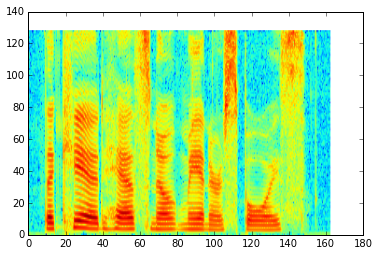

(129, 324)
(129, 100)


In [4]:
[framerate,sound]=wavfile.read("SI2048_.wav")
(spectrum, freqs, t, im)=specgram(sound,NFFT=256,Fs=256)
plt.show()
wavPlayer("SI2048_.wav")
print(np.shape(spectrum))
print(np.shape(spectrum[:129,:100]))


In [95]:
def findData():
    print("finding files")
    inputFiles = []
    target = []
    basePath =  os.getcwd()+"\\timit\\timit\\train"
    for path, subdirs, files in os.walk(basePath):
        print(".",end="")
        for name in files:
             if (name[-5:]=="_.WAV"):
                loc="\\".join((path,name))
                inputFiles.append(loc)
                split=loc.split("\\")
                if split[-2][0]=="m":
                    target.append(1)
                elif split[-2][0]=="f":
                    target.append(0)
                else:
                    print(split)
                    raise ValueError("something fishy is going on")
                
                
    print("found {0} files".format(len(target)))
    return inputFiles,target

In [83]:
def loadData(files,targets):
    print("loading data. Reporting progres...")
    n=len(files)
    X=np.empty((n,1,129,100))
    y=np.array(targets,dtype=int).reshape(-1,1)
    for i,elem in enumerate(files):
        if i % (int(n/10))==0:
            print(i/float(n))
        [framerate,sound]=wavfile.read("SI2048_.wav")
        (spectrum, freqs, t, _)=specgram(sound,NFFT=256,Fs=256)
        X[i,:,:]=spectrum[:129,:100]
    print("done")
    return X,y

In [96]:
[files,targets]=findData()

finding files
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................found 4620 files


loading data. Reporting progres...
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
done


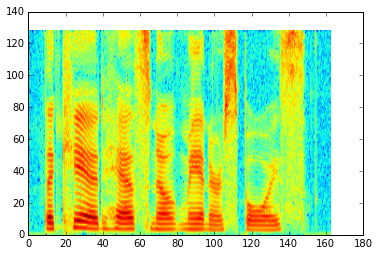

In [97]:
[X,y]=loadData(files[:300],targets[:300])

(300, 300)

C:\Users\frederik\Documents\dtu\advanced\boom\timit\timit\train\dr1\fcjf0\SA1_.WAV , male/female: 0


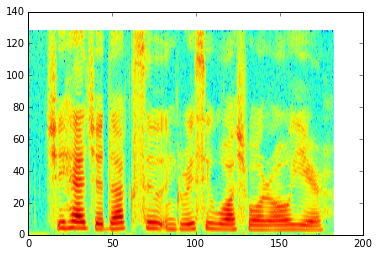

(129, 364)

In [9]:
print(files[0],", male/female: {0}".format(targets[0]))
[framerate,sound]=wavfile.read(files[0])
(spectrum, freqs, t, im)=specgram(sound,NFFT=256,Fs=256)
plt.show()
wavPlayer(files[0])
np.shape(spectrum)

In [35]:
def buildCnn(input_var=None):
    print("building cnn")
    #input
    network = lasagne.layers.InputLayer(shape=(None, 1, 129, 100),
                                        input_var=input_var)
    print("shape: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #conv
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(129, 8),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    print("shape: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #max pool
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(1, 4))
    print("shape: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #conv
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(1, 8),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    print("shape: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #max pool
    network = lasagne.layers.MaxPool2DLayer(
            network, pool_size=(1, 4))
    print("shape: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #dense
    network = lasagne.layers.DenseLayer(
            network, num_units=100,
            nonlinearity=lasagne.nonlinearities.rectify)
    print("shape: {0}".format(lasagne.layers.get_output_shape(network)))
    
    #dense
    out = lasagne.layers.DenseLayer(
            network, num_units=1,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    print("shape: {0}".format(lasagne.layers.get_output_shape(out)))
    
    return out

In [114]:
print("setting up model")
input_var = T.tensor4('inputs')
target_var = T.imatrix('targets')
network=buildCnn(input_var)
print("\tbuilding prediction/loss")
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.binary_crossentropy(prediction, target_var)
loss = loss.mean()
print("\tbuilding params/updates")
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)
print("\tbuilding test prediction/loss")
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.binary_crossentropy(test_prediction,target_var)
print("\tbuilding test loss/acc")
test_loss = test_loss.mean()
binaryPrediction = test_prediction > .5
test_acc = T.mean(T.eq(binaryPrediction, target_var.T))
#test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
#                      dtype=theano.config.floatX)
print("\tbuilding train/val functions")
train_fn = theano.function([input_var, target_var], loss, updates=updates)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
print("\ndone")

setting up model
building cnn
shape: (None, 1, 129, 100)
shape: (None, 32, 1, 93)
shape: (None, 32, 1, 23)
shape: (None, 32, 1, 16)
shape: (None, 32, 1, 4)
shape: (None, 100)
shape: (None, 1)
	building prediction/loss
	building params/updates
	building test prediction/loss
	building test loss/acc
	building train/val functions

done


In [90]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [111]:
train_fn(X[:10].reshape(-1,1,129,100),y[:10])

array(3901.891964770385)

In [94]:
len(y)

100

In [115]:
print("training!")
numEpochs=10
for epoch in range(numEpochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X, y, 100, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)

            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        #for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
        #    inputs, targets = batch
        #    err, acc = val_fn(inputs, targets)
        #    val_err += err
        #    val_acc += acc
        #    val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, numEpochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        #print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        #print("  validation accuracy:\t\t{:.2f} %".format(
        #    val_acc / val_batches * 100))
print("done")

training!
Epoch 1 of 10 took 1.670s
  training loss:		22028443371616475817999576596480.000000
Epoch 2 of 10 took 1.534s
  training loss:		1517665359038749289026781828098024726181084665766722992123245436250344499498953697229375173248279272112273288475967488.000000
Epoch 3 of 10 took 1.534s
  training loss:		65485845673893960490214749080636111580956889400656828575558242551453551285058013504055999926338017939294367463400945959247966851176022368793973486695801788825600.000000
Epoch 4 of 10 took 1.567s
  training loss:		47364442338249262612536456845528619506265343425499485351903811473280947474411353607653299428132582116650373592054384008605678658976509692449080917422296268800.000000
Epoch 5 of 10 took 1.606s
  training loss:		94246153871459018546013656935370893402380902008762421233785929910333771060202936702203594879925637544030726609542045643170806734635832057589024867633367875584.000000
Epoch 6 of 10 took 1.541s
  training loss:		13539837530946506254037274158028592089756969965423326374438

In [118]:
print(inputs.shape)
print(targets.shape)
train_fn(inputs, targets)

(100, 1, 129, 100)
(100, 1)


array(2.6354723130901e+158)

In [130]:
lasagne.layers.get_output(network,X)

sigmoid.0

In [129]:
y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    